# Notations

$(0,T]$:  The observation interval during which neuron spiking activity were recorded

$N_{0,t}^i$: Sample path of spike times from the recorded i-th neuron in $(0,t]$, for $t \in (0,T]$, $i \in \{1,...,n\}$

$K$: divide $(0,T]$ into $K$ intervals with width $\Delta = \frac{T}{K}$ such that there is at most one spike per interval

$k\Delta$: The point at which the latent process model is evaluated, for $k = 1,...,K$

$y^i_k = \Delta N_k^i$: The number of spikes at time k for i-th neuron.

$H_K^i = \{\Delta y_{1}^i,...,\Delta y_{K}^i\}$: history of spiking activity in $(0,K]$ for i-th neuron

$\pi_{c_i=c}$: probability of the i-th neuron belongs to cluster c

## Define the 1-dimensional state space model

$$\left\{
\begin{array}{ll}
      x_k^i = x_{k-1}^i + \epsilon_k^i, \epsilon_k \sim N(0,\sigma^2_{\epsilon i}) & (a) \\
      \lambda_k^i(k\Delta)\Delta = \frac{e^{x_k^i}}{1+e^{x_k^i}} & (b)\\
      y_{k}^i | x_k^i \sim Bernoulli(\lambda_k^i(k\Delta)\Delta) & (c)
\end{array} 
\right. $$

\begin{align*}
E[\log p(y, x, c)|y, \theta^{(l-1)}] &= E[\sum_{i=1}^n \log p(y^i, x^i|c_i;\theta_i) \pi_{c_i} |y,\theta^{(l-1)}]\\
&= \sum_{i=1}^n \{E[\log p(x^i|c_i;\sigma^2_{\epsilon c_i})|y^i;\theta^{(l-1)}]] + E[\log \pi_{c_i}|y^i;\theta^{(l-1)}] + E[\log p(y^i|x^i)|y^i;\theta^{(l-1)}]\}
\end{align*}

\begin{align*}
\sum_{i=1}^n E[\log p(x^i|c_i;\sigma^2_{\epsilon i})|y^i;\theta^{(l-1)}]] &= \sum_{i=1}^n \sum_{c} (-\frac{K}{2} \log \sigma_{\epsilon c_i}^2 -\frac{1}{2\sigma_{\epsilon c_i}^2} \sum_{k=1}^K E[(x_k-x_{k-1})^2|c_i,y^i,\theta^{(l-1)}]) * p(c_i=c|y^i,\theta^{(l-1)})\\
\end{align*}

### $p(c_i=c|y^i)=\frac{p(y^i|c_i=c)p(c_i=c)}{\sum_{c} p(y^i|c_i=c)p(c_i=c)}$

trick: normalize $exp(\log p(y^i|c_i=c) - \max (\log p(y^i|c_i \in \{clusters\})))$

### $\sigma_{c}^2 = \frac{\sum_{i=1}^n \sum_k (W_{i,k}+W_{i,k-1}-2W_{i,k,k-1})p(c_i=c|y^i,\sigma^{(l-1)})}{K \sum_{i=1}^n p(c_i=c|y^i,\sigma^{(l-1)})}$


### $\pi_{c} = \frac{\sum_{i=1}^n p(c_i=c|y^i,\sigma^{(l-1)})}{ \sum_{c} \sum_{i=1}^n p(c_i=c|y^i,\sigma^{(l-1)})}$

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
#         lpy = np.empty(N)
#         g = self.calc_g(particles=particles, t=t)
 

#         if (g is None):
#             g = np.repeat(self.g.reshape((1, -1, 1)), N, 0)
#         else:
#             g = g.reshape((N, -1, 1))
        yrep = np.repeat(np.asarray(y), N, 0)
    
        lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
    
        return lpy

In [4]:
# Forward particles
N = 100
# Backward trajectories
M = 30
# trials
trial = 50
# cluster
cluster = 2
#iterations
iteration = 10
#
sigma_ls = np.empty([iteration,cluster])
pi_ls = np.empty([iteration,cluster])

In [5]:
mat = np.loadtxt('train_data.txt')
Y = mat[:,1:]
T = Y.shape[1]
n = Y.shape[0]

In [6]:
pi=[0.5,0.5]

In [7]:
sigma=[0.2,0.3]

In [35]:
#for j in range(n):
#    posterior_of_indicator(cluster, pi, Y[j,:], sigma, N, T, trial)

(20, 3000)

In [ ]:
%%time
sigmatmp = np.zeros([cluster,n])
loglikelihood = np.empty([cluster,n])
posterior_indicator = np.empty([cluster,n])
for i in range(iteration):
    for j in range(n):
        for c in range(cluster):
            P0 = sigma[c] * np.eye(1)
            Q = sigma[c] * np.eye(1)
            model = StdNonLin(P0, Q)
            sim = simulator.Simulator(model,u=None,y=Y[j,:])
            sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
            (est_filt, w_filt) = sim.get_filtered_estimates()
            est_smooth = sim.get_smoothed_estimates()
            w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[j,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
            loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
            posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
            sigmatmp[c,j] = np.sum(posteriorcovariance/(M*T))


    posterior_indicator = np.exp(loglikelihood - np.max(loglikelihood, axis=0)) * np.reshape(np.repeat(pi,20),(2,20))
    posterior_indicator = posterior_indicator/np.sum(posterior_indicator, axis=0)
    pii = np.sum(posterior_indicator,axis=1)/np.sum(posterior_indicator)
    sigma = np.sum(sigmatmp * posterior_indicator, axis=1)/np.sum(posterior_indicator,axis=1)
    sigma_ls[i,:]=sigma
    pi_ls[i,:]=pii

In [47]:
sigmatmp

array([[ 0.53891569,  0.48040307,  0.452297  ,  0.49260845,  0.44286219,
         0.45651843,  0.47465474,  0.47526403,  0.484885  ,  0.47472063,
         0.56981627,  0.53362058,  0.53505096,  0.53370316,  0.51525393,
         0.49620973,  0.50787046,  0.52801137,  0.54531409,  0.5436029 ],
       [ 0.54000846,  0.56199093,  0.53189763,  0.58434475,  0.51659312,
         0.540427  ,  0.55883366,  0.56162608,  0.57882836,  0.54664204,
         0.67441574,  0.62151396,  0.63619943,  0.62825799,  0.61221338,
         0.58713782,  0.59155165,  0.62273077,  0.64418348,  0.63130678]])

In [49]:
sigma

array([ 0.48821698,  0.62007522])

In [39]:
np.sum(sigmatmp * posterior_indicator, axis=1)/np.sum(posterior_indicator,axis=1)

array([ 0.7117355 ,  0.85354167])

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


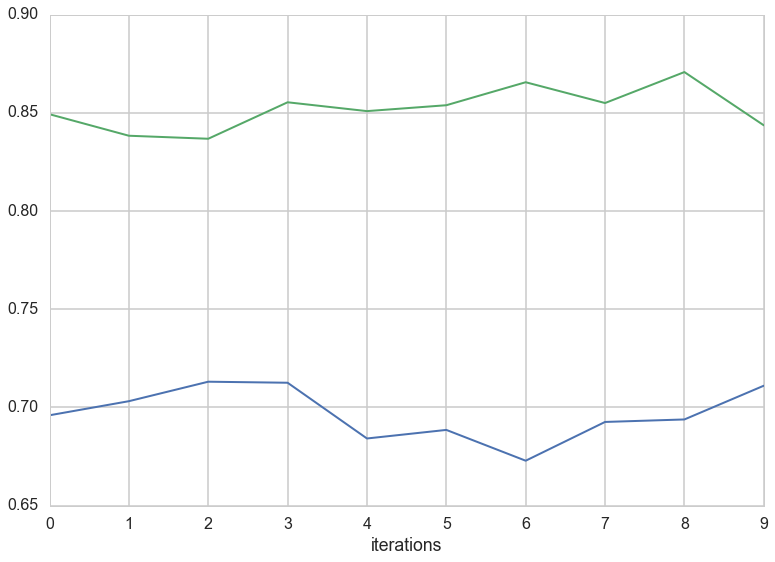

In [218]:
plt.plot(sigma_ls, '-',linewidth=2.0)
plt.xlabel('iterations')
plt.legend(loc='best')

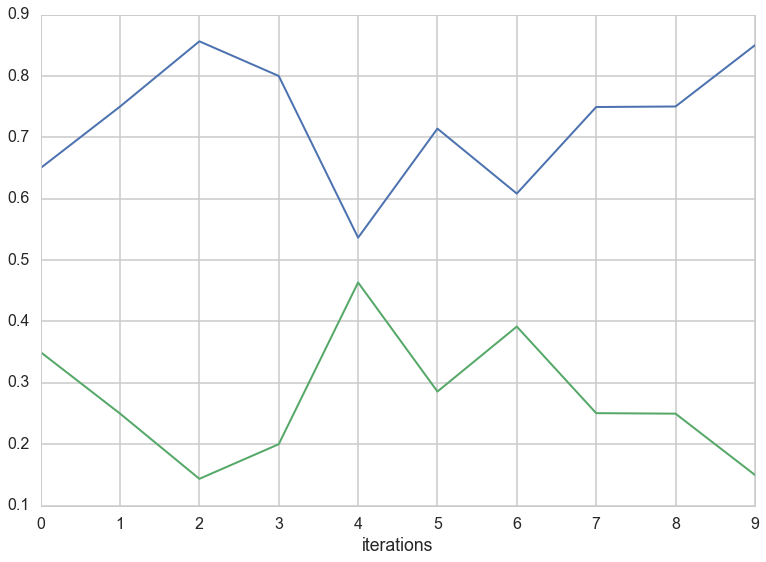

In [219]:
plt.plot(pi_ls, '-',linewidth=2.0)
plt.xlabel('iterations')
plt.legend(loc='best')

In [17]:
sigma_ls

array([[  7.07960140e-001,   8.59188572e-001],
       [  7.10719096e-001,   8.59475913e-001],
       [  7.13481848e-001,   8.69145125e-001],
       [  7.13319245e-001,   8.79130649e-001],
       [  6.99208119e-001,   8.78696070e-001],
       [  7.19842642e-001,   8.52654375e-001],
       [  7.23370229e-001,   8.45025472e-001],
       [  7.18877413e-001,   8.61204214e-001],
       [  7.18081401e-001,   8.73125521e-001],
       [  7.07229504e-001,   8.70520288e-001],
       [  7.17359164e-001,   8.53707834e-001],
       [  7.12710853e-001,   8.53541669e-001],
       [  2.37151510e-322,   1.08221785e-312],
       [  0.00000000e+000,   2.66795449e-322],
       [  1.20958716e-312,   0.00000000e+000],
       [  2.96439388e-322,   1.33685735e-312],
       [  0.00000000e+000,   3.26083326e-322],
       [  1.46417710e-312,   2.20411637e-314],
       [  3.55727265e-322,   1.59181405e-312],
       [  0.00000000e+000,   2.00000012e+000]])

In [18]:
pi_ls

array([[ 0.74737257,  0.25262743],
       [ 0.75971493,  0.24028507],
       [ 0.80001586,  0.19998414],
       [ 0.79999999,  0.20000001],
       [ 0.67139587,  0.32860413],
       [ 0.94382841,  0.05617159],
       [ 0.81603826,  0.18396174],
       [ 0.79999071,  0.20000929],
       [ 0.83770903,  0.16229097],
       [ 0.69926991,  0.30073009],
       [ 0.8010205 ,  0.1989795 ],
       [ 0.73124484,  0.26875516],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [19]:
i

12

In [20]:
posterior_indicator

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.12139011e-24,   9.77332989e-01,
          7.99945585e-16,   1.00000000e+00,   7.28097685e-01,
          1.04592584e-10,   8.42315025e-26,   9.99818187e-01,
          9.19647944e-01,   3.03655485e-11],
       [  2.99698197e-23,   3.67838197e-17,   1.30641907e-17,
          1.65368158e-18,   1.29324669e-22,   7.79878317e-15,
          3.29770694e-12,   7.62214605e-20,   9.86696068e-13,
          5.03914463e-17,   1.00000000e+00,   2.26670110e-02,
          1.00000000e+00,   1.60434773e-11,   2.71902315e-01,
          1.00000000e+00,   1.00000000e+00,   1.81813485e-04,
          8.03520556e-02,   1.00000000e+00]])

In [ ]:
def posterior_of_indicator(cluster, pi, Y, sigma, N, T, trial):
    posterior_indicator = np.empty(cluster)
    loglikelihood = np.empty(cluster)
    w_unnormalized = []
    for c in range(cluster):
        P0 = sigma[c] * np.eye(1)
        Q = sigma[c] * np.eye(1)
        model = StdNonLin(P0, Q)
        sim = simulator.Simulator(model,u=None,y=Y)
        sim.simulate(N, M, filter='PF', smoother='full', meas_first=False)
        (est_filt, w_filt) = sim.get_filtered_estimates()
        w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y,N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
        loglikelihood[c] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
        #posterior_of_indicator[i] = np.exp(loglikelihood[i])*pi[i]/np.sum(np.exp(loglikelihood[i])*pi[i])
        posterior_indicator[c] = np.exp(loglikelihood[i] + np.log(pi[i]) - np.log(np.sum(np.exp(loglikelihood[i])*pi[i])))
    return posterior_indicator

In [ ]:
%%time
sigmatmp = np.zeros([cluster,n])
loglikelihood = np.empty([cluster,n])
posterior_indicator = np.empty([cluster,n])
#posterior_joint = np.empty([cluster, n])
for j in range(n):
    for c in range(cluster):
        P0 = sigma[c] * np.eye(1)
        Q = sigma[c] * np.eye(1)
        model = StdNonLin(P0, Q)
        sim = simulator.Simulator(model,u=None,y=Y[j,:])
        sim.simulate(N, M, filter='PF', smoother='full', meas_first=False)
        (est_filt, w_filt) = sim.get_filtered_estimates()
        est_smooth = sim.get_smoothed_estimates()
        w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[j,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
        loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
        #posterior_of_indicator[i] = np.exp(loglikelihood[i])*pi[i]/np.sum(np.exp(loglikelihood[i])*pi[i])
        #posterior_indicator[c] = np.exp(loglikelihood[c] + np.log(pi[c]) - np.log(np.sum(np.exp(loglikelihood[c])*pi[c])))
        #posterior_joint[c,j] = np.exp(loglikelihood[c]) * pi[c]
        posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
        sigmatmp[c,j] = np.sum(posteriorcovariance/(M*T))

for j in range(n):
    for c in range(cluster):
        posterior_indicator[c,j]=np.exp(loglikelihood[c,j] - np.max(loglikelihood[:,j])) * pi[c] / np.dot(np.exp(loglikelihood[:,j] - np.max(loglikelihood[:,j])), pi)

for c in range(cluster):
    sigma[c] = np.dot(sigmatmp[c,:],posterior_indicator[c,:])/np.sum(posterior_indicator[c,:])
    pi[c] = np.sum(posterior_indicator[c,:])/np.sum(posterior_indicator)

In [75]:
P0 = sigma[0] * np.eye(1)
Q = sigma[0] * np.eye(1)
model = StdNonLin(P0, Q)
sim = simulator.Simulator(model,u=None,y=Y[0,:])
sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
(est_filt, w_filt) = sim.get_filtered_estimates()
est_smooth = sim.get_smoothed_estimates()
w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[0,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
sigmatmp = np.sum(posteriorcovariance/(M*T))

In [76]:
sigmatmp

0.19128461492363608

array([[ 0.48821698]])